## Dependencies

In [4]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

### Connecting to PostgreSQL database

In [ ]:
from sqlalchemy import create_engine
import db_credentials

In [ ]:
# Using the database credentials
db_connection = db_credentials.db_credentials

In [ ]:
# Accessing individual credentials from the dictionary of credentials
user = db_connection['user']
password = db_connection['password']
host = db_connection['host']
port = db_connection['port']
database = db_connection['database']

# Creating connection string
connection_str = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# SQLAlchemy engine
engine = create_engine(connection_str)

# Test if the connection is made or not
try:
    with engine.connect() as connection_str:
        print('Successfully connected to the PostgreSQL database')
except Exception as ex:
    print(f'Sorry failed to connect: {ex}')

### Query data from PostgreSQL and create a DataFrame 

In [5]:
# Establish a connection to the PostgreSQL database (This connection allows us to execute SQL querie)
conn = engine.connect()

# Execute SQL query
result = conn.execute('SELECT * FROM "AIDs_Classifications"')
        
# Fetch all rows from the result set
rows = result.fetchall()
        
# Convert result set to DataFrame
AIDS_df = pd.DataFrame(rows, columns=result.keys())
        
# Print the DataFrame
AIDS_df.head()

,ID,treatment,ZDV_only_treatment,off_treatment,time,age,weight,hemophilia,homosexual_activity,drugs,...,ZDV_last_30days,prior_ART_length,ART_history,ART_history_stratified,symptom,cd4_base,cd4_20wks,cd8_base,cd8_20wks,infected
0,0,2,1,0,948,48,89.8128,0,0,0,...,0,0,0,1,0,422,477,566,324,0
1,1,3,1,0,1002,61,49.4424,0,0,0,...,1,895,1,3,0,162,218,392,564,1
2,2,3,1,1,961,45,88.4520,0,1,1,...,1,707,1,3,0,326,274,2063,1893,0
3,3,3,1,0,1166,47,85.2768,0,1,0,...,1,1399,1,3,0,287,394,1590,966,0
4,4,0,0,0,1090,43,66.6792,0,1,0,...,1,1352,1,3,0,504,353,870,782,0


## Preprocessing

In [5]:
# This can be used for getting the data directly from the CSV located in the Resources folder
AIDS_df = pd.read_csv('Resources/AIDS_Classifications_cleaned.csv')

In [6]:
# Drop the non-benificial columns based on the data exploration 
AIDS_df = AIDS_df.drop(['ID', 'cd8_base', 'cd8_20wks', 'homosexual_activity','prior_ART_length' ], axis = 1)
AIDS_df.head()

,treatment,ZDV_only_treatment,off_treatment,time,age,weight,hemophilia,drugs,race,gender,karnofsky_score,therapy_prior,ZDV_last_30days,ART_history,ART_history_stratified,symptom,cd4_base,cd4_20wks,infected
0,2,1,0,948,48,89.8128,0,0,0,0,100,0,0,0,1,0,422,477,0
1,3,1,0,1002,61,49.4424,0,0,0,0,90,0,1,1,3,0,162,218,1
2,3,1,1,961,45,88.4520,0,1,0,1,90,0,1,1,3,0,326,274,0
3,3,1,0,1166,47,85.2768,0,0,0,1,100,0,1,1,3,0,287,394,0
4,0,0,0,1090,43,66.6792,0,0,0,1,100,0,1,1,3,0,504,353,0


In [7]:
# Determine the number of unique values in each column.
AIDS_df.nunique()

treatment                   4
ZDV_only_treatment          2
off_treatment               2
time                      713
age                        59
weight                    667
hemophilia                  2
drugs                       2
race                        2
gender                      2
karnofsky_score             4
therapy_prior               2
ZDV_last_30days             2
ART_history                 2
ART_history_stratified      3
symptom                     2
cd4_base                  484
cd4_20wks                 570
infected                    2
dtype: int64

In [8]:
# Print DataFrame structure
print(AIDS_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   treatment               2139 non-null   int64  
 1   ZDV_only_treatment      2139 non-null   int64  
 2   off_treatment           2139 non-null   int64  
 3   time                    2139 non-null   int64  
 4   age                     2139 non-null   int64  
 5   weight                  2139 non-null   float64
 6   hemophilia              2139 non-null   int64  
 7   drugs                   2139 non-null   int64  
 8   race                    2139 non-null   int64  
 9   gender                  2139 non-null   int64  
 10  karnofsky_score         2139 non-null   int64  
 11  therapy_prior           2139 non-null   int64  
 12  ZDV_last_30days         2139 non-null   int64  
 13  ART_history             2139 non-null   int64  
 14  ART_history_stratified  2139 non-null   

In [9]:
# There are significantly more '0's than '1's
infected_count = AIDS_df["infected"].value_counts()
infected_count

infected
0    1618
1     521
Name: count, dtype: int64

### Handling class imbalance
The above code indicates that our classes are very imbalanced. Handling class imbalance is crucial in machine learning when one class has significantly more samples than the other. 

To handle this issue we have used the following strategies:
1. Oversampling Method: SMOTE (Synthetic Minority Over-sampling Technique) is an oversampling method used to address the problem of class imbalance in machine learning. 
2. Algorithmic techniques: adjust the class weights in the model to penalize misclassifications of the minority class more than the majority class. This can be achieved by setting the class_weight parameter to “balanced” in some models such as Logistic Regression and SVM 
3. Using ensemble methods like Random Forests which inherently handle class imbalance by combining multiple weak learners.
4. Evaluation Metrics: Use appropriate evaluation metrics that are less sensitive to class imbalance, such as precision, and recall rather than accuracy.



# SMOTE (Synthetic Minority Oversampling Technique)

In [10]:
# Split our preprocessed data into our features and target arrays
y = AIDS_df['infected'].ravel()
x = AIDS_df.drop(columns='infected')

# Define the train-test split size
test_size = 0.2
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1,stratify=y)


In [11]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [12]:
# Convert y_train_res back to a Pandas Series for value_counts()
y_train_res_series = pd.Series(y_train_res)

In [17]:

print(y_train_res_series.value_counts())


1    1294
0    1294
Name: count, dtype: int64


In [26]:
# print the number and shape of train and test data
print(f"Feature=> train: {X_train_res.shape} - test: {X_test.shape}")
print(f"Label=> train: {y_train_res.shape} - test: {y_test.shape}")

Feature=> train: (2588, 18) - test: (428, 18)
Label=> train: (2588,) - test: (428,)


In [16]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train_res)

# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train_res)
X_test_scaled = X_scaler.transform(X_test)

## Model 1: Logistic Regression + Model 2: K-NearestNeighbors (KNN) + Model 3: Support Vector Machine (SVM) 

In [80]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Define a function to evaluate models
def evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test):
    # Train the model using the training data
    model.fit(X_train_scaled, y_train)
    
    # Create predictions using the training and testing data
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate accuracy
    acc_train = model.score(X_train_scaled, y_train)
    acc_test = model.score(X_test_scaled, y_test)
    
    # Calculate precision, recall, F1-score, and support
    p_train, r_train, f1_train, support_train = precision_recall_fscore_support(y_train, y_pred_train, average='macro')
    p_test, r_test, f1_test, support_test = precision_recall_fscore_support(y_test, y_pred_test, average='macro')
    
    # Generate classification report
    report = classification_report(y_test, y_pred_test, target_names=["not infected", "infected"])
    
    return acc_train, acc_test, p_train, r_train, f1_train, support_train, p_test, r_test, f1_test, support_test, report

# Perform an 80:20 train-test split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
X_train_res, y_train_res = sm.fit_resample(X_train_split, y_train_split)

# Standardize the features
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test_split)

# Logistic Regression
logistic_reg = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1, class_weight="balanced")
acc_train_logistic_reg, acc_test_logistic_reg, p_train_logistic_reg, r_train_logistic_reg, f1_train_logistic_reg, support_train_logistic_reg, p_test_logistic_reg, r_test_logistic_reg, f1_test_logistic_reg, support_test_logistic_reg, report_logistic_reg = evaluate_model(logistic_reg, X_train_scaled, X_test_scaled, y_train_res, y_test_split)
print("Logistic Regression:")
print(f"Accuracy (Train): {acc_train_logistic_reg}")
print(f"Accuracy (Test): {acc_test_logistic_reg}")
print(f"Precision (Train): {p_train_logistic_reg}")
print(f"Recall (Train): {r_train_logistic_reg}")
print(f"F1-score (Train): {f1_train_logistic_reg}")
print(f"Support (Train): {support_train_logistic_reg}")
print(f"Precision (Test): {p_test_logistic_reg}")
print(f"Recall (Test): {r_test_logistic_reg}")
print(f"F1-score (Test): {f1_test_logistic_reg}")
print(f"Support (Test): {support_test_logistic_reg}")
print("Classification Report:")
print(report_logistic_reg)
print("---------------------------------------")

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
acc_train_knn, acc_test_knn, p_train_knn, r_train_knn, f1_train_knn, support_train_knn, p_test_knn, r_test_knn, f1_test_knn, support_test_knn, report_knn = evaluate_model(knn, X_train_scaled, X_test_scaled, y_train_res, y_test_split)
print("K-Nearest Neighbors:")
print(f"Accuracy (Train): {acc_train_knn}")
print(f"Accuracy (Test): {acc_test_knn}")
print(f"Precision (Train): {p_train_knn}")
print(f"Recall (Train): {r_train_knn}")
print(f"F1-score (Train): {f1_train_knn}")
print(f"Support (Train): {support_train_knn}")
print(f"Precision (Test): {p_test_knn}")
print(f"Recall (Test): {r_test_knn}")
print(f"F1-score (Test): {f1_test_knn}")
print(f"Support (Test): {support_test_knn}")
print("Classification Report:")
print(report_knn)
print("---------------------------------------")

# Support Vector Machine
svm = SVC(kernel='linear', class_weight="balanced")
acc_train_svm, acc_test_svm, p_train_svm, r_train_svm, f1_train_svm, support_train_svm, p_test_svm, r_test_svm, f1_test_svm, support_test_svm, report_svm = evaluate_model(svm, X_train_scaled, X_test_scaled, y_train_res, y_test_split)
print("Support Vector Machine:")
print(f"Accuracy (Train): {acc_train_svm}")
print(f"Accuracy (Test): {acc_test_svm}")
print(f"Precision (Train): {p_train_svm}")
print(f"Recall (Train): {r_train_svm}")
print(f"F1-score (Train): {f1_train_svm}")
print(f"Support (Train): {support_train_svm}")
print(f"Precision (Test): {p_test_svm}")
print(f"Recall (Test): {r_test_svm}")
print(f"F1-score (Test): {f1_test_svm}")
print(f"Support (Test): {support_test_svm}")
print("Classification Report:")
print(report_svm)
print("---------------------------------------")

Logistic Regression:
Accuracy (Train): 0.8597372488408037
Accuracy (Test): 0.8387850467289719
Precision (Train): 0.8605919781713736
Recall (Train): 0.8597372488408037
F1-score (Train): 0.8596540815907316
Support (Train): None
Precision (Test): 0.7806916577288304
Recall (Test): 0.8184354226020893
F1-score (Test): 0.7954493506493506
Support (Test): None
Classification Report:
              precision    recall  f1-score   support

not infected       0.92      0.86      0.89       324
    infected       0.64      0.78      0.70       104

    accuracy                           0.84       428
   macro avg       0.78      0.82      0.80       428
weighted avg       0.85      0.84      0.84       428

---------------------------------------
K-Nearest Neighbors:
Accuracy (Train): 0.9447449768160742
Accuracy (Test): 0.8247663551401869
Precision (Train): 0.9451493351425506
Recall (Train): 0.9447449768160742
F1-score (Train): 0.9447324260258357
Support (Train): None
Precision (Test): 0.7623806804

Comparing the results for three available distributions of the dataset indicates that all three models have a better performance when train_test split ratio distribution is considered 70:30 (or 0.7).
We have used the results for this distribution in the final comparison.


In [21]:
# SVM modelcompare the actual and predicated dataset
# Select a subset of your dataset (e.g., first 100 samples)
subset_X = pd.DataFrame(X_test_scaled[:100])
subset_y_actual = pd.Series(y_test[:100])

# Predictions on the subset
subset_y_pred = svm.predict(subset_X)

# Comparison
comparison_df = pd.DataFrame({'Actual': subset_y_actual, 'Predicted': subset_y_pred})

print(comparison_df)

    Actual  Predicted
0        0          0
1        1          0
2        0          1
3        0          0
4        0          1
..     ...        ...
95       0          0
96       0          0
97       0          0
98       0          1
99       0          0

[100 rows x 2 columns]


## Methodology:
We utilized three traditional classification algorithms: Logistic Regression, K-Nearest Neighbors (KNN), and Support Vector Machine (SVM).  
The dataset was split into training and testing sets using : 80:20  
Evaluation metrics included accuracy, precision, recall, F1-score, and support.  

## Logistic Regression:  
Achieved an accuracy of approximately 83% across all train-test split ratios.  
Displayed balanced precision and recall for the "not infected" class, indicating robust performance in correctly identifying individuals not infected with the AIDS virus.  
However, precision and recall for the "infected" class were relatively lower, suggesting challenges in correctly classifying individuals infected with the virus.  

## K-Nearest Neighbors (KNN):  
Produced an accuracy is 78%.  
Demonstrated relatively lower precision and recall for both classes compared to Logistic Regression, indicating a less optimal performance in classification.  

## Support Vector Machine (SVM):  
Attained an accuracy close to Logistic Regression, from 84%.  
Showed balanced precision and recall for both classes, indicating effective classification performance.  
After evaluating the performance of the SVM model with subset of the data, the model seems to perform reasonably well on the subset  of data, correctly predicting the outcomes for many samples. 



## Model 5: RandomForest Model

In [ ]:
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


### Create rf_df DataFrame and Add Columns 'cd4_propdif' and 'cd4_numerical_change'

In [71]:
### Create rf_df DataFrame and Add Columns 'cd4_propdif' and 'cd4_numerical_change'

# Calculate proportional differences in CD4 count
rf_df = AIDS_df
rf_df['cd4_propdif'] = (AIDS_df['cd4_20wks'] - AIDS_df['cd4_base']) / AIDS_df['cd4_base']
rf_df['cd4_numerical_change'] = (AIDS_df['cd4_20wks'] - AIDS_df['cd4_base'])

# Display the DataFrame to verify the changes

selected_columns = rf_df[['time', 'age', 'weight', 'cd4_base', 'cd4_20wks', 'cd4_propdif', 'cd4_numerical_change']]

#print
selected_columns.head()

,time,age,weight,cd4_base,cd4_20wks,cd4_propdif,cd4_numerical_change
0,948,48,89.8128,422,477,0.130332,55
1,1002,61,49.4424,162,218,0.345679,56
2,961,45,88.4520,326,274,-0.159509,-52
3,1166,47,85.2768,287,394,0.372822,107
4,1090,43,66.6792,504,353,-0.299603,-151


In [72]:
rf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   treatment               2139 non-null   int64  
 1   ZDV_only_treatment      2139 non-null   int64  
 2   off_treatment           2139 non-null   int64  
 3   time                    2139 non-null   int64  
 4   age                     2139 non-null   int64  
 5   weight                  2139 non-null   float64
 6   hemophilia              2139 non-null   int64  
 7   drugs                   2139 non-null   int64  
 8   race                    2139 non-null   int64  
 9   gender                  2139 non-null   int64  
 10  karnofsky_score         2139 non-null   int64  
 11  therapy_prior           2139 non-null   int64  
 12  ZDV_last_30days         2139 non-null   int64  
 13  ART_history             2139 non-null   int64  
 14  ART_history_stratified  2139 non-null   

### DefineFeatures and Target Columns, Train, Make Predictions

In [73]:
# Define Features and Target Columns
feature_columns = ['treatment', 'ZDV_only_treatment', 'off_treatment', 'time', 'age',
                   'weight', 'hemophilia', 'drugs', 'race',
                   'gender', 'karnofsky_score', 'therapy_prior', 'ZDV_last_30days',
                 'ART_history', 'ART_history_stratified', 'symptom',
                   'cd4_base', 'cd4_20wks']
target = 'infected'

# Split the data into features and target
X = rf_df[feature_columns]
y = rf_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize RandomForest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)

# Train the Model
random_forest_classifier.fit(X_train_res, y_train_res)

# Make Predictions
predictions = random_forest_classifier.predict(X_test)

# Print Classification Report
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.92      0.93      0.92       327
           1       0.76      0.73      0.75       101

    accuracy                           0.88       428
   macro avg       0.84      0.83      0.84       428
weighted avg       0.88      0.88      0.88       428



### Generate Model Statistics

In [74]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, predictions)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, predictions)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, predictions)
print("F1-score:", f1)

# Generate Classification Report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Generate Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

Accuracy: 0.883177570093458
Precision: 0.7628865979381443
Recall: 0.7326732673267327
F1-score: 0.7474747474747475

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       327
           1       0.76      0.73      0.75       101

    accuracy                           0.88       428
   macro avg       0.84      0.83      0.84       428
weighted avg       0.88      0.88      0.88       428


Confusion Matrix:
[[304  23]
 [ 27  74]]


### Prediction Error Plot

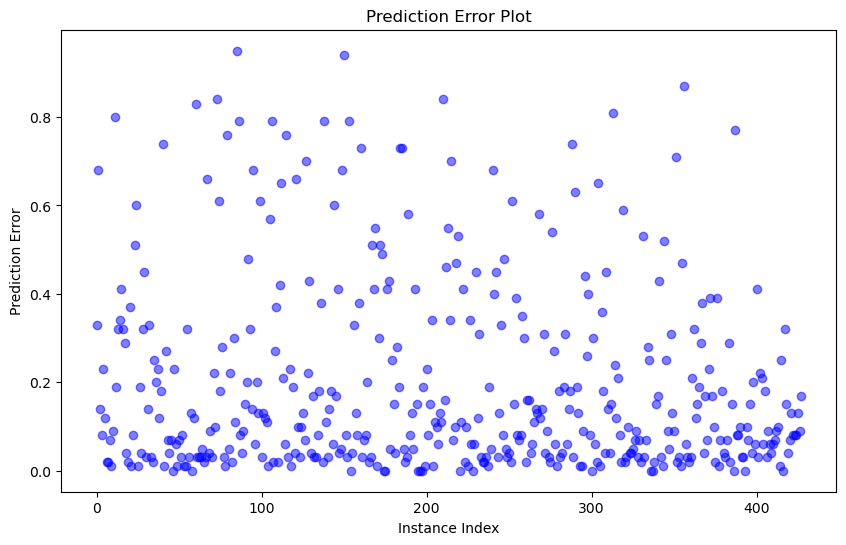

In [75]:
# Calculate prediction probabilities
probabilities = random_forest_classifier.predict_proba(X_test)
predicted_probabilities = probabilities[:, 1]  # Probability of class 1 (positive class)

# Calculate prediction errors
prediction_errors = np.abs(y_test - predicted_probabilities)

# Plot prediction errors
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), prediction_errors, color='blue', alpha=0.5)
plt.title('Prediction Error Plot')
plt.xlabel('Instance Index')
plt.ylabel('Prediction Error')
plt.show()

### Extract and Visualise Feature Importance in the Model

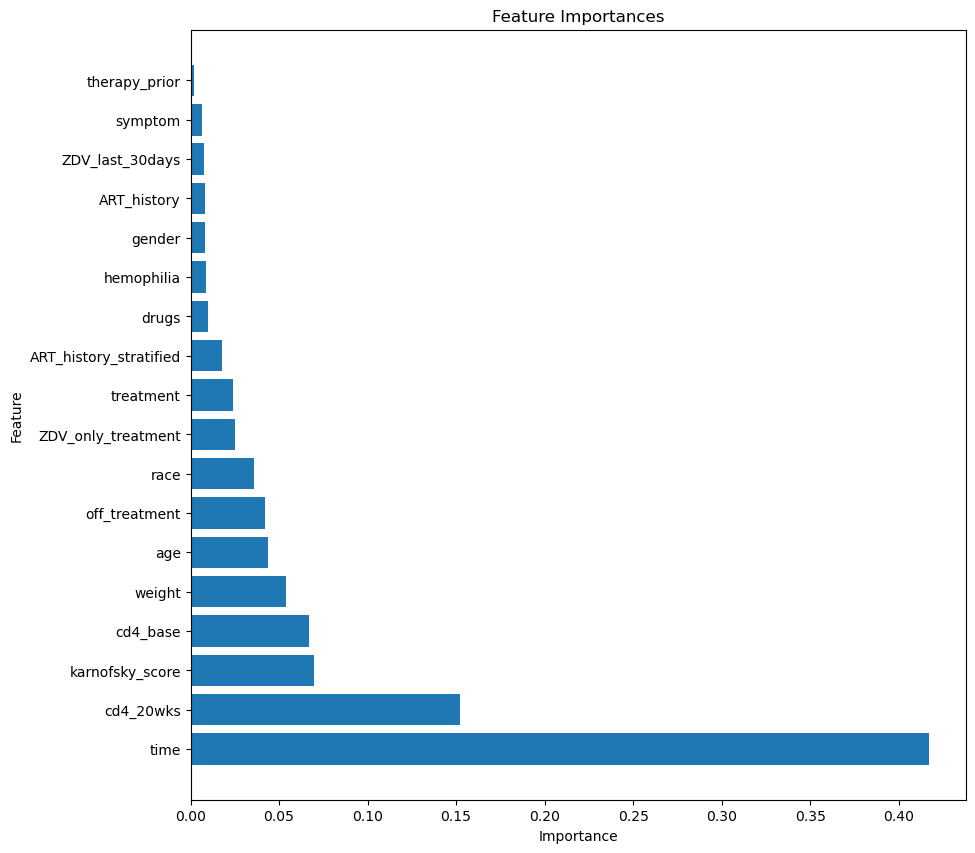

In [76]:
# Extract feature importances
feature_importances = random_forest_classifier.feature_importances_
# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({"Feature": feature_columns, "Importance": feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 10))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()

## Model 4_1: Deep Neural Networks(DNN)

In [22]:
# Define a function to calculate accuracy_score, precision_score, and recall_score for different algorithms
from sklearn.metrics import accuracy_score, precision_score, recall_score
def calculate_metrics(y_train, y_test, y_pred_train, y_pred_test):
    acc_train = round(accuracy_score(y_true=y_train, y_pred=y_pred_train), 2)
    acc_test = round(accuracy_score(y_true=y_test, y_pred=y_pred_test), 2)

    p = round(precision_score(y_true=y_test, y_pred=y_pred_test), 2)
    r = round(recall_score(y_true=y_test, y_pred=y_pred_test), 2)

    print(f"acc train: {acc_train}, acc test: {acc_test}, precision: {p}, recall: {r}")

    return acc_train, acc_test, p, r

#### Compile, Train and Evaluate the Model

In [26]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer
# Determine the number of input features
input_features = X_train_res.shape[1]

# Create the Keras Sequential model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=30, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 80)                  │           1,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │           2,430 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,981 (15.55 KB)

 Trainable params: 3,981 (15.55 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train_res, epochs=50)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5989 - loss: 0.6443
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8315 - loss: 0.3921
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8696 - loss: 0.3008
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8917 - loss: 0.2691
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9007 - loss: 0.2389
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8956 - loss: 0.2372
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9165 - loss: 0.2139
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9236 - loss: 0.2044
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9199 - loss: 0.1938
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9311 - loss: 0.1732
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9245 - loss: 0.1879
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9388 - lo

In [29]:
# Evaluate the model using the function to calculate different metrics for this model
# Create predictions using the testing data
y_pred_train = nn.predict(X_train_scaled)>0.5
y_pred_test = nn.predict(X_test_scaled)>0.5

# Calling the function to calculate the metrics
print(f"Metrics for Nural Network model_1: ")
acc_train_knn, acc_test_knn, p_knn, r_knn = calculate_metrics(y_train_res, y_test, y_pred_train, y_pred_test)

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
Metrics for Nural Network model_1: 
acc train: 0.98, acc test: 0.64, precision: 0.27, recall: 0.27


In [30]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

14/14 - 0s - 10ms/step - accuracy: 0.6449 - loss: 2.2027
Loss: 2.202688694000244, Accuracy: 0.644859790802002


## Model 4_2: Deep Neural Networks(DNN)

Attempt 1: Use same structure but different number of nurons in each layer and increasing the Epoch from 50 t0 100. Also the number of units from 80 and 30 have changed to 14 and 7 as well.

In [31]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# Determine the number of input features
number_input_features = len( X_train_scaled[0])
hidden_nodes_layer1=14
hidden_nodes_layer2=7
nn = tf.keras.models.Sequential()

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 14)                  │             266 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 379 (1.48 KB)

 Trainable params: 379 (1.48 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train_res, epochs=100)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5028 - loss: 0.8675
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5470 - loss: 0.6832
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6636 - loss: 0.6114
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7486 - loss: 0.5522
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8021 - loss: 0.5187
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8388 - loss: 0.4779
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8360 - loss: 0.4590
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.8520 - loss: 0.4299
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8694 - loss: 0.4159
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8847 - loss: 0.3981  
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8794 - loss: 0.3777
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accur

In [34]:
# Evaluate the model using the function to calculate different metrics for this model
# Create predictions using the testing data
y_pred_train = nn.predict(X_train_scaled)>0.5
y_pred_test = nn.predict(X_test_scaled)>0.5

# Calling the function to calculate the metrics
print(f"Metrics for Nural Network model_2: ")
acc_train_nn, acc_test_nn, p_nn, r_nn = calculate_metrics(y_train_res, y_test, y_pred_train, y_pred_test)

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
Metrics for Nural Network model_2: 
acc train: 0.95, acc test: 0.67, precision: 0.31, recall: 0.3


In [35]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

14/14 - 0s - 10ms/step - accuracy: 0.6682 - loss: 1.4292
Loss: 1.4291925430297852, Accuracy: 0.6682242751121521


## Model 4_3: Deep Neural Networks(DNN)

Attempt 2: Optimising the structure using the Keras Tuner

* Allow activation function to choose between relu, sigmoid, tanh
 *  sigmoid is still the only option for the final layer
* Allow number of neurons to vary from 6 to ~75
* Allow for 1, 2, or 3 extra hidden layers (not input or output)


In [38]:
import keras_tuner as kt

NUM_FEATURES = X_train_res.shape[1]
print("Features:", NUM_FEATURES)

def create_model(hp: kt.HyperParameters) -> tf.keras.models.Sequential:
    model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice("activation", ["relu", "sigmoid", "tanh"])

    # Allow kerastuner to decide number of neurons in first layer
    model.add(tf.keras.layers.Dense(units=hp.Int("first_units", 6, NUM_FEATURES*2, step=6),
                                    activation=activation,
                                    input_dim=NUM_FEATURES))
    
    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     6, NUM_FEATURES*2, step=6),
                                        activation=activation))
    # output layer
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy"])
    return model

tuner = kt.Hyperband(create_model,
                     objective="val_accuracy",
                     max_epochs=25,
                     overwrite=True,
                     hyperband_iterations=2)

Features: 18


In [39]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,
             y_train_res,
             epochs=25,
             validation_data=(X_test_scaled, y_test))

Trial 60 Complete [00h 00m 08s]
val_accuracy: 0.663551390171051

Best val_accuracy So Far: 0.7570093274116516
Total elapsed time: 00h 04m 07s


In [40]:
# Get top 3 model hyperparameters and print the values
top_3_hp = tuner.get_best_hyperparameters(3)
for hparam in top_3_hp:
    print(hparam.values)

# Evaluate the top 3 models against the test dataset
top_3_model = tuner.get_best_models(3)
for model in top_3_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

{'activation': 'sigmoid', 'first_units': 6, 'num_layers': 3, 'units_0': 12, 'units_1': 24, 'units_2': 18, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
{'activation': 'sigmoid', 'first_units': 18, 'num_layers': 3, 'units_0': 18, 'units_1': 18, 'units_2': 36, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
{'activation': 'sigmoid', 'first_units': 6, 'num_layers': 3, 'units_0': 12, 'units_1': 24, 'units_2': 18, 'tuner/epochs': 9, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0002'}
14/14 - 0s - 18ms/step - accuracy: 0.7570 - loss: 0.6778
Loss: 0.6777974963188171, Accuracy: 0.7570093274116516
14/14 - 0s - 21ms/step - accuracy: 0.7570 - loss: 0.6470
Loss: 0.6469507217407227, Accuracy: 0.7570093274116516
14/14 - 0s - 19ms/step - accuracy: 0.7570 - loss: 0.6764
Loss: 0.6764254570007324, Accuracy: 0.7570093274116516


In [41]:
best_tuned_model = tuner.get_best_models(1)[0]
# Evaluate the model using the test data
model_loss2, model_accuracy2 = best_tuned_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss2}, Accuracy: {model_accuracy2}")

14/14 - 0s - 19ms/step - accuracy: 0.7570 - loss: 0.6778
Loss: 0.6777974963188171, Accuracy: 0.7570093274116516


In [42]:
# Define the best model offered by Keras Tuner
input_features = X_train_scaled.shape[1]
best_model = tf.keras.models.Sequential()

# Add the first hidden layer
best_model.add(tf.keras.layers.Dense(units=30, activation='relu', input_dim=input_features))

# Add the second hidden layer
best_model.add(tf.keras.layers.Dense(units=12, activation='relu'))

# Add the third hidden layer
best_model.add(tf.keras.layers.Dense(units=24, activation='relu'))

# Add the output layer
best_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with appropriate number of epochs and batch size
history = best_model.fit(X_train_scaled, y_train_res, epochs=25, batch_size=32, verbose=2)

# Evaluate the model on the test dataset
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/25
81/81 - 1s - 16ms/step - accuracy: 0.7241 - loss: 0.5938
Epoch 2/25
81/81 - 0s - 2ms/step - accuracy: 0.8308 - loss: 0.4050
Epoch 3/25
81/81 - 0s - 2ms/step - accuracy: 0.8733 - loss: 0.3139
Epoch 4/25
81/81 - 0s - 1ms/step - accuracy: 0.8941 - loss: 0.2787
Epoch 5/25
81/81 - 0s - 1ms/step - accuracy: 0.9022 - loss: 0.2594
Epoch 6/25
81/81 - 0s - 2ms/step - accuracy: 0.9065 - loss: 0.2438
Epoch 7/25
81/81 - 0s - 1ms/step - accuracy: 0.9073 - loss: 0.2334
Epoch 8/25
81/81 - 0s - 1ms/step - accuracy: 0.9119 - loss: 0.2229
Epoch 9/25
81/81 - 0s - 1ms/step - accuracy: 0.9162 - loss: 0.2146
Epoch 10/25
81/81 - 0s - 1ms/step - accuracy: 0.9231 - loss: 0.2065
Epoch 11/25
81/81 - 0s - 1ms/step - accuracy: 0.9247 - loss: 0.2008
Epoch 12/25
81/81 - 0s - 1ms/step - accuracy: 0.9258 - loss: 0.1963
Epoch 13/25
81/81 - 0s - 1ms/step - accuracy: 0.9316 - loss: 0.1903
Epoch 14/25
81/81 - 0s - 1ms/step - accuracy: 0.9304 - loss: 0.1852
Epoch 15/25
81/81 - 0s - 1ms/step - accuracy: 0.9312 - l

In [44]:
# Evaluate the model using the function to calculate different metrics for this model
# Create predictions using the testing data
y_pred_train = best_model.predict(X_train_scaled)>0.5
y_pred_test = best_model.predict(X_test_scaled)>0.5

# Calling the function to calculate the metrics
print(f"Metrics for Nural Network model_3: ")
acc_train_best_model, acc_test_best_model, p_best_model, r_best_model = calculate_metrics(y_train_res, y_test, y_pred_train, y_pred_test)

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Metrics for Nural Network model_3: 
acc train: 0.95, acc test: 0.65, precision: 0.28, recall: 0.29


## Model 4_4: Deep Neural Networks(DNN)

In this attempt, we will keep the 7 first important features according to the horizontal bar chart plotted in the Random Forest model.

In [56]:
# Drop the columns with lower importance according to the Random Forest "Feature Importance bar chart".
new_AIDS_df = AIDS_df.drop([ 'treatment', 'ZDV_only_treatment', 'hemophilia', 'drugs', 'race',
       'gender', 'therapy_prior', 'ZDV_last_30days','ART_history', 'ART_history_stratified', 'symptom','cd4_propdif','cd4_numerical_change'], axis = 1)
new_AIDS_df.head()

,off_treatment,time,age,weight,karnofsky_score,cd4_base,cd4_20wks,infected
0,0,948,48,89.8128,100,422,477,0
1,0,1002,61,49.4424,90,162,218,1
2,1,961,45,88.4520,90,326,274,0
3,0,1166,47,85.2768,100,287,394,0
4,0,1090,43,66.6792,100,504,353,0


In [57]:
new_AIDS_df.columns

Index(['off_treatment', 'time', 'age', 'weight', 'karnofsky_score', 'cd4_base',
       'cd4_20wks', 'infected'],
      dtype='object')

In [58]:
# Split our preprocessed data into our features and target arrays
y = new_AIDS_df['infected'].ravel()
x = new_AIDS_df.drop(columns='infected')

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=1)

In [63]:
sm = SMOTE(random_state=42) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Convert y_train_res back to a Pandas Series for value_counts()
y_train_res_series = pd.Series(y_train_res)

print(y_train_res_series.value_counts())


0    1309
1    1309
Name: count, dtype: int64


In [64]:
# print the number and shape of train and test data
print(f"Feature=> train: {X_train.shape} - test: {X_test.shape}")
print(f"Label=> train: {y_train.shape} - test: {y_test.shape}")

Feature=> train: (1711, 7) - test: (428, 7)
Label=> train: (1711,) - test: (428,)


In [65]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train_res)

# Scale the data
X_train_scaled = X_scaler.transform(X_train_res)
X_test_scaled = X_scaler.transform(X_test)

In [67]:
# Define the best model offered by Keras Tuner in previous model but with new DataFrame
input_features = X_train_scaled.shape[1]
best_model = tf.keras.models.Sequential()

# Add the first hidden layer
best_model.add(tf.keras.layers.Dense(units=30, activation='relu', input_dim=input_features))

# Add the second hidden layer
best_model.add(tf.keras.layers.Dense(units=12, activation='relu'))

# Add the third hidden layer
best_model.add(tf.keras.layers.Dense(units=24, activation='relu'))

# Add the output layer
best_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with appropriate number of epochs and batch size
history = best_model.fit(X_train_scaled, y_train_res, epochs=25, batch_size=32, verbose=2)

# Evaluate the model on the test dataset
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/25
82/82 - 1s - 16ms/step - accuracy: 0.7819 - loss: 0.5443
Epoch 2/25
82/82 - 0s - 2ms/step - accuracy: 0.8461 - loss: 0.3779
Epoch 3/25
82/82 - 0s - 2ms/step - accuracy: 0.8751 - loss: 0.3173
Epoch 4/25
82/82 - 0s - 2ms/step - accuracy: 0.8766 - loss: 0.2940
Epoch 5/25
82/82 - 0s - 2ms/step - accuracy: 0.8820 - loss: 0.2801
Epoch 6/25
82/82 - 0s - 1ms/step - accuracy: 0.8862 - loss: 0.2733
Epoch 7/25
82/82 - 0s - 1ms/step - accuracy: 0.8850 - loss: 0.2665
Epoch 8/25
82/82 - 0s - 1ms/step - accuracy: 0.8866 - loss: 0.2608
Epoch 9/25
82/82 - 0s - 1ms/step - accuracy: 0.8869 - loss: 0.2551
Epoch 10/25
82/82 - 0s - 1ms/step - accuracy: 0.8900 - loss: 0.2547
Epoch 11/25
82/82 - 0s - 1ms/step - accuracy: 0.8976 - loss: 0.2496
Epoch 12/25
82/82 - 0s - 1ms/step - accuracy: 0.8900 - loss: 0.2492
Epoch 13/25
82/82 - 0s - 1ms/step - accuracy: 0.8908 - loss: 0.2473
Epoch 14/25
82/82 - 0s - 1ms/step - accuracy: 0.8934 - loss: 0.2442
Epoch 15/25
82/82 - 0s - 1ms/step - accuracy: 0.8957 - l

In [69]:
# Evaluate the model using the function to calculate different metrics for this model
# Create predictions using the testing data
y_pred_train = best_model.predict(X_train_scaled)>0.5
y_pred_test = best_model.predict(X_test_scaled)>0.5

# Calling the function to calculate the metrics
print(f"Metrics for Nural Network model_4: ")
acc_train_best_model_4, acc_test_best_model_4, p_best_model_4, r_best_model_4 = calculate_metrics(y_train_res, y_test, y_pred_train, y_pred_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Metrics for Nural Network model_4: 
acc train: 0.91, acc test: 0.85, precision: 0.7, recall: 0.8


## Comparission the metrics for all the models

In [81]:
import matplotlib.pyplot as plt

# Define metrics for all models
acc_test = [0.84, 0.82, 0.84, acc_test_best_model_4, 0.88]
precision = [0.64, 0.62, 0.64, p_best_model_4, 0.76]
recall = [0.76, 0.71, 0.76, r_best_model_4, 0.73]
title = ["Logistic Regression", "KNN", "SVM", "DNN", "Random Forest"]
colour = ["blue", "orange", "green", "red", "black"]

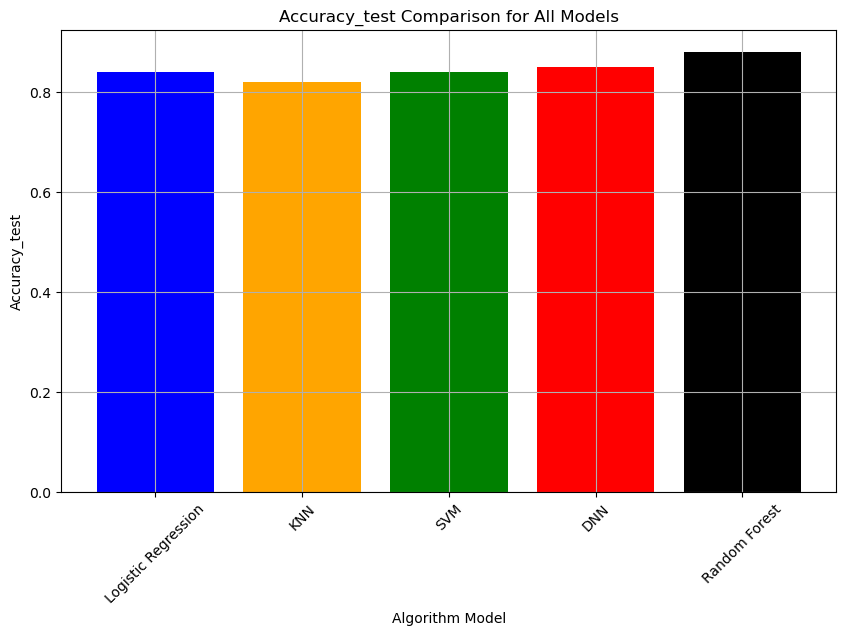

In [82]:
# Plotting accuracy for train and test data
plt.figure(figsize=(10, 6))
plt.bar(title, acc_test, color=colour, label="Test")
plt.grid()
plt.title("Accuracy_test Comparison for All Models")
plt.xlabel("Algorithm Model")
plt.ylabel("Accuracy_test")
plt.xticks(rotation=45)
plt.show()

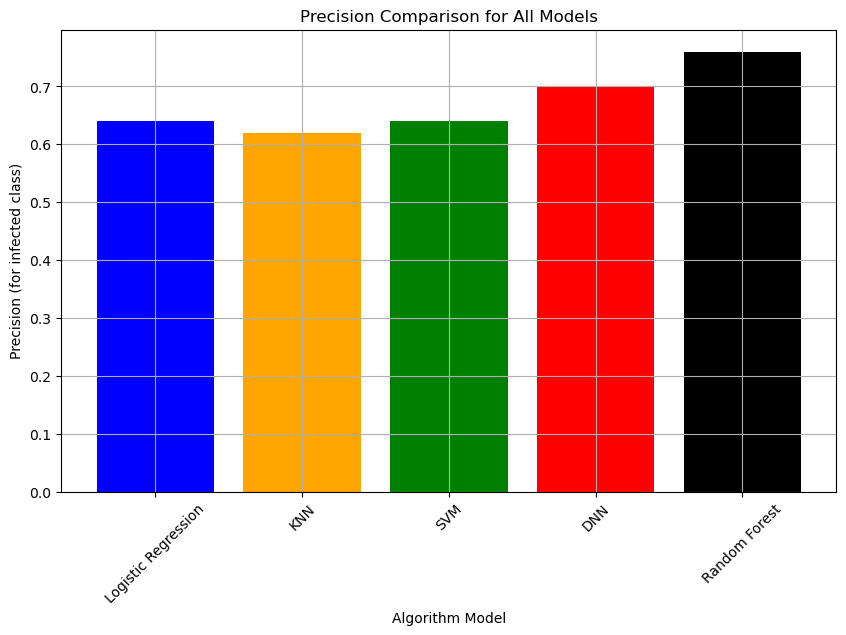

In [83]:
# Plotting precision for all models
plt.figure(figsize=(10, 6))
plt.bar(title, precision, color=colour)
plt.grid()
plt.title("Precision Comparison for All Models")
plt.xlabel("Algorithm Model")
plt.ylabel("Precision (for infected class)")
plt.xticks(rotation=45)
plt.show()

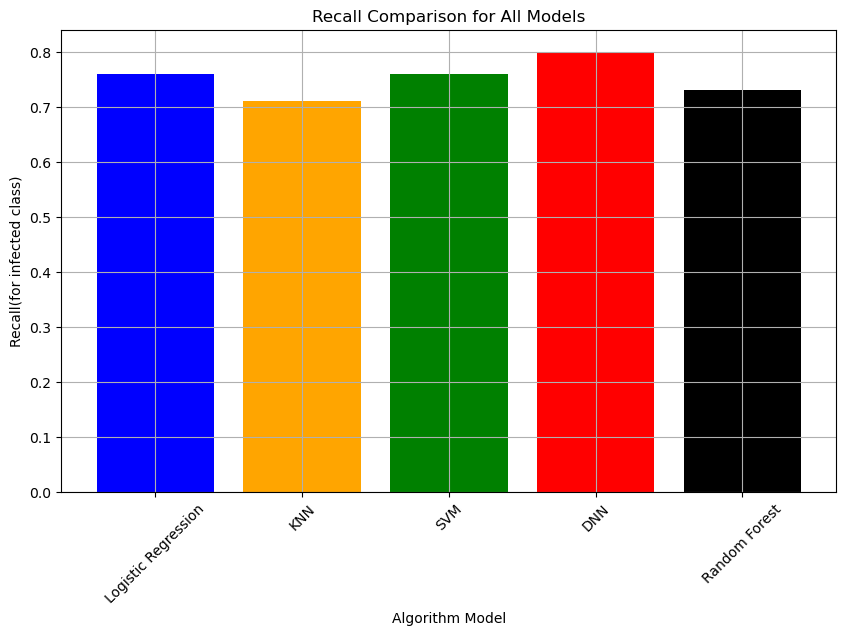

In [84]:
# Plotting recall for all models
plt.figure(figsize=(10, 6))
plt.bar(title, recall, color=colour)
plt.grid()
plt.title("Recall Comparison for All Models")
plt.xlabel("Algorithm Model")
plt.ylabel("Recall(for infected class)")
plt.xticks(rotation=45)
plt.show()

Overall Conclusion:

1. Random Forest provides highest accuracy 88% and precision 76%, and its recall is also reasonably high 73%.
   
2. Neural Network model in its 4th attempts shows  highest recall 80%, but precision is 70% which is lower than that of Random Forest.  
   
According to the concept of our medical dataset and the importance of predicting individuals infected with AIDS in order to getting timely treatment, accuracy and recall for the infected class(class 1)  are considered as the most important metrics for choosing the best model in this project. So Neural Network is the best model with an accuracy of 85% and a recall of 80%.
